In [1]:
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row
import math
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from operator import mul
from operator import add
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.linalg import Vectors
import numpy as np
import pandas as pd
import pyspark.sql.functions as func

from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

%matplotlib inline

In [2]:
week2 = spark.read.parquet("/Users/49132/Documents/big data/tw623-nyu_ml/week2/mortgage_sample")
week4 = spark.read.parquet("/Users/49132/Documents/big data/tw623-nyu_ml/week4/mortgage_sample_week4")


week2.printSchema()
week2.show()

week4.printSchema()
week4.show()

root
 |-- FICO: double (nullable = true)
 |-- CLEANLTV: double (nullable = true)
 |-- INCENTIVE: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- FIRSTTIMEBUYER: double (nullable = true)
 |-- INVESTOR: double (nullable = true)
 |-- SECONDHOME: double (nullable = true)
 |-- SEASON: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)

+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|751.0|    61.0|0.006200000000000004|19.0|           0.0|     0.0|       0.0|  12.0|    1|[751.0,61.0,0.006...|
|751.0|    61.0|0.008200000000000006|20.0|           0.0|     0.0|       0.0|   1.0|    1|[751.0,61.0,0.008...|
|751.0|    61.0|              0.0085|2

In [3]:
def analyze_model(model, dataset):
	pred1 = model.transform(dataset)
	pred_entropy = pred1.rdd.map(lambda x : -math.log(1.0e-100 + x["probability"][int(x["label"])]))
	h1 = pred_entropy.reduce(lambda x, y : x + y) / pred1.count()
	
	pred_mod_entropy = pred1.rdd.map(lambda x : -sum(map(mul, map(math.log, map(lambda z: z + 1.0e-100, x["probability"])), x["probability"])))
	h2 = pred_mod_entropy.reduce(lambda x, y : x + y) / pred1.count()
	return (h1, h2)


def check_one(name, fitter, ds1, ds2): 
	model = fitter.fit(ds1)
	(h1, h2) = analyze_model(model, ds1)
	(h3, h4) = analyze_model(model, ds2)
	print(name + ", " + str(h1) + ", " + str(h3) + ", " + str(h2) + ", " + str(h4))


def extract(row):
    return (row.FICO, row.CLEANLTV, row.INCENTIVE, row.AGE, row.label, row.prediction) + tuple(row.probability.toArray().tolist())



def test_classifier(name, model_mlp, df_in, df_out, group_by):

    (h1, h2) = analyze_model(model_mlp, df_in)
    (h3, h4) = analyze_model(model_mlp, df_out)
    print(name + ", " + str(h1) + ", " + str(h3) + ", " + str(h2) + ", " + str(h4))
    
    res_mlp = model_mlp.transform(df_out)
    plot_mlp = res_mlp.rdd.map(extract).toDF(["FICO", "CLEANLTV", "INCENTIVE", "AGE", "label", "prediction", "prob_p", "prob_c", "prob_3"])    
    grouped_mlp = plot_mlp.groupBy(group_by).agg(func.avg("prob_p"), func.count("prob_p"), func.avg("prob_3"), func.avg("prob_c"))
    df_mlp = pd.DataFrame(grouped_mlp.collect(), columns=[group_by, 'avg(prob_p)', 'count(prob_p)', 'avg(prob_3)', 'avg(prob_c)'])
    return df_mlp


def rescale_sample(df_sample, df_stats): 
    df_sample = df_sample.withColumn('label', df_sample['label'] - 1)
    df_sample = df_sample.withColumn('FICO2', (df_sample['FICO'] - df_stats.agg(func.avg('FICO')).collect()[0]['avg(FICO)']) / (df_stats.agg(func.stddev('FICO')).collect()[0]['stddev_samp(FICO)']))
    df_sample = df_sample.withColumn('AGE2', (df_sample['AGE'] - df_stats.agg(func.avg('AGE')).collect()[0]['avg(AGE)']) / (df_stats.agg(func.stddev('AGE')).collect()[0]['stddev_samp(AGE)']))
    df_sample = df_sample.withColumn('CLEANLTV2', (df_sample['CLEANLTV'] - df_stats.agg(func.avg('CLEANLTV')).collect()[0]['avg(CLEANLTV)']) / (df_stats.agg(func.stddev('CLEANLTV')).collect()[0]['stddev_samp(CLEANLTV)']))
    df_sample = df_sample.withColumn('INCENTIVE2', (df_sample['INCENTIVE'] - df_stats.agg(func.avg('INCENTIVE')).collect()[0]['avg(INCENTIVE)']) / (df_stats.agg(func.stddev('INCENTIVE')).collect()[0]['stddev_samp(INCENTIVE)']))
    df_sample = df_sample.withColumn('SEASON2', (df_sample['SEASON'] - df_stats.agg(func.avg('SEASON')).collect()[0]['avg(SEASON)']) / (df_stats.agg(func.stddev('SEASON')).collect()[0]['stddev_samp(SEASON)']))

    # Now repackage the features.
    df_sample = df_sample.drop("features")
    
    assembler = VectorAssembler(
        inputCols=('FICO2', 'CLEANLTV2', 'INCENTIVE2', 'AGE2', 'FIRSTTIMEBUYER', 'INVESTOR', 'SECONDHOME', 'SEASON2'),
        outputCol='features')
        
    df_sample = assembler.transform(df_sample)
    
    df_sample = df_sample.drop("FICO2")
    df_sample = df_sample.drop("CLEANLTV2")
    df_sample = df_sample.drop("INCENTIVE2")
    df_sample = df_sample.drop("AGE2")
    df_sample = df_sample.drop("SEASON2")

    return df_sample

    



MLP, 0.18842761441731187, 0.18212222443692624, 0.188783644559, 0.188751404553
7A, 0.1942584697826001, 0.18851578779477662, 0.194844702213, 0.194633794878
MLP, 0.18842761441731187, 0.18212222443692624, 0.188783644559, 0.188751404553
7A, 0.1942584697826001, 0.18851578779477662, 0.194844702213, 0.194633794878


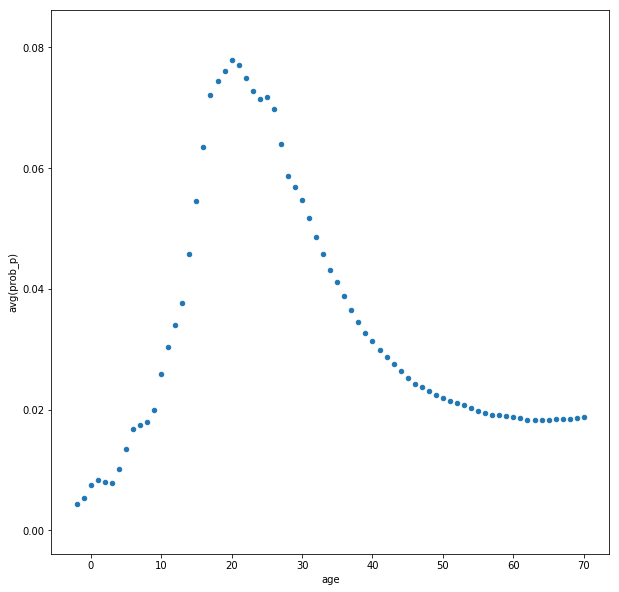

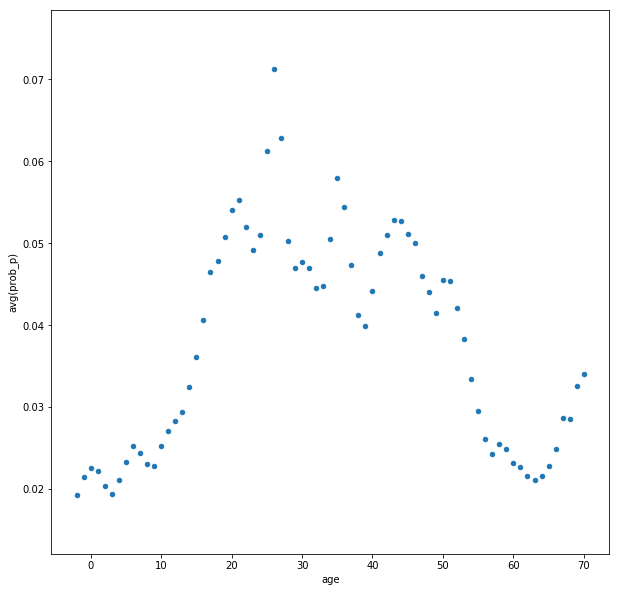

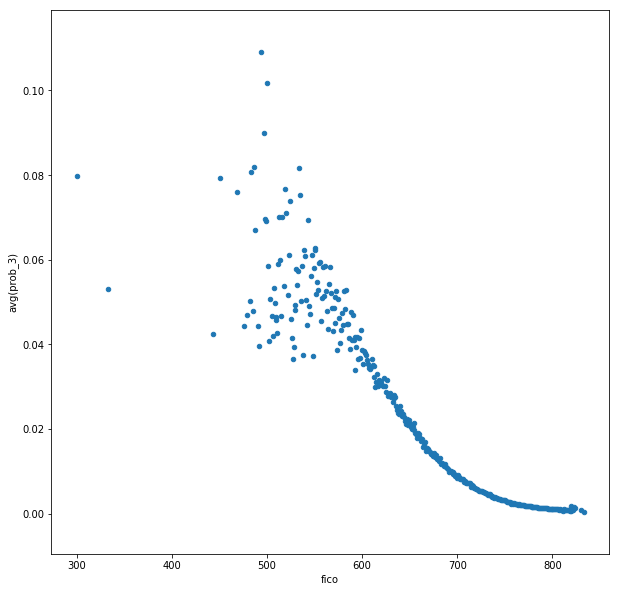

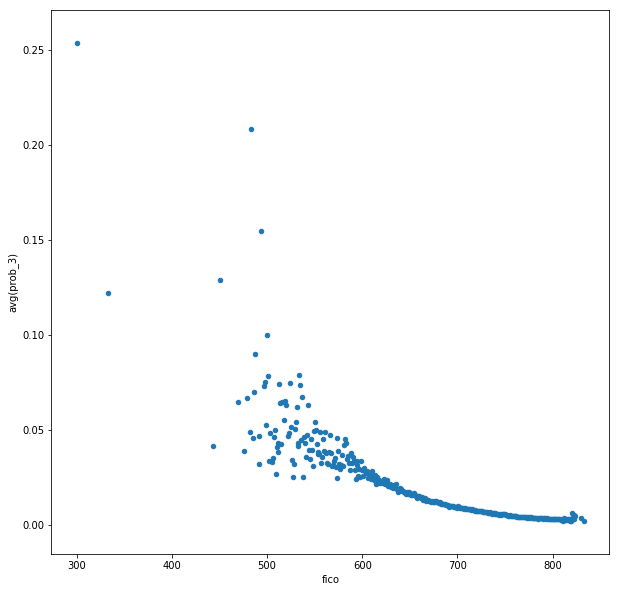

In [20]:
df_in = week2.sample(False,150000/(1.0*week2.count()),seed =1)
df_out = week2.sample(False,150000/(1.0*week4.count()),seed =2)

# N.B: Why does this take two data sets? 
df_in2 = rescale_sample(df_in, df_in)
df_out2 = rescale_sample(df_out, df_in)

fitter_mlp = MultilayerPerceptronClassifier(maxIter=100, tol=1e-10, layers=[8,3,3], blockSize=128, seed=1234, probabilityCol='probability')
model_mlp = fitter_mlp.fit(df_in2)

fitter_logistic = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100, regParam=0.001, elasticNetParam=0.001)
model_logistic = fitter_logistic.fit(df_in2)

test_classifier("MLP", model_mlp, df_in2, df_out2, "age").plot(kind='scatter', x='age', y='avg(prob_p)', figsize=(10,10))
test_classifier("7A", model_logistic, df_in2, df_out2, "age").plot(kind='scatter', x='age', y='avg(prob_p)', figsize=(10,10))

test_classifier("MLP", model_mlp, df_in2, df_out2, "fico").plot(kind='scatter', x='fico', y='avg(prob_3)', figsize=(10,10))
test_classifier("7A", model_logistic, df_in2, df_out2, "fico").plot(kind='scatter', x='fico', y='avg(prob_3)', figsize=(10,10))




In [33]:
result = model_mlp.transform(df_in2)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))
result = model_mlp.transform(df_out2)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))


Test set accuracy = 0.955179054290019
Test set accuracy = 0.9569877408056042


In [6]:
# Strip down to just two features.
df_in = df_in.drop("features")
df_out = df_out.drop("features")

assembler = VectorAssembler(
    inputCols=('FICO', 'CLEANLTV'),
    outputCol='features')

df_in = assembler.transform(df_in)
df_out = assembler.transform(df_out)

In [7]:
fitter_mlp = MultilayerPerceptronClassifier(maxIter=1000, layers=[8, 8, 8, 6, 4, 3], blockSize=128, seed=1234, probabilityCol='probability')

model_logistic = fitter_logistic.fit(df_in2)
model_mlp = fitter_mlp.fit(df_in2)


In [8]:
res_mlp = model_mlp.transform(df_out2)
res_logistic = model_logistic.transform(df_out2)



+-----+--------+-----+----------+--------------------+------------------+--------------------+
| FICO|CLEANLTV|label|prediction|              prob_p|            prob_c|              prob_3|
+-----+--------+-----+----------+--------------------+------------------+--------------------+
|715.0|    80.0|    1|       1.0| 0.03944205051625414|0.9531588318455319|0.007399117638214027|
|680.0|    59.0|    1|       1.0|0.037415233266394066|0.9584064597263758|0.004178307007230...|
|680.0|    59.0|    0|       1.0|0.037415233266394066|0.9584064597263758|0.004178307007230...|
|563.0|    64.0|    1|       1.0|0.020823084523149987|0.9337970565549801| 0.04537985892186983|
|563.0|    64.0|    1|       1.0|0.020823084523149987|0.9337970565549801| 0.04537985892186983|
|563.0|    64.0|    1|       1.0|0.020823084523149987|0.9337970565549801| 0.04537985892186983|
|757.0|    79.0|    1|       1.0| 0.03823897748357153|0.9595063226542427|0.002254699862185...|
|675.0|    95.0|    1|       1.0|0.029815807802208

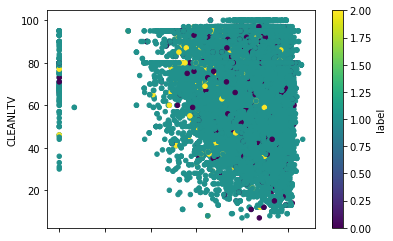

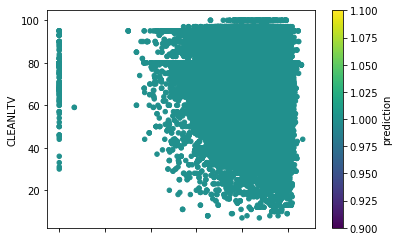

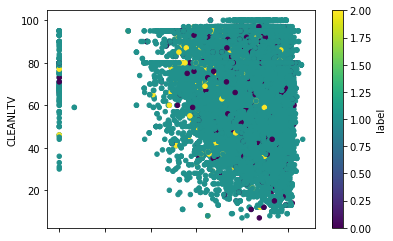

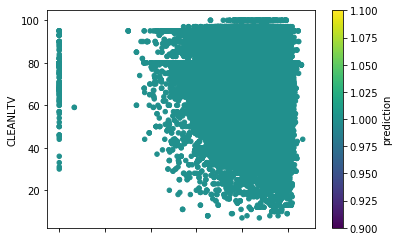

In [42]:
def extract(row):
    return (row.FICO, row.CLEANLTV, row.label,row.prediction) + (tuple(row.probability.toArray().tolist()))

packed_mlp = res_mlp.rdd.map(extract).toDF(["FICO", "CLEANLTV", "label", "prediction", "prob_p", "prob_c", "prob_3"])
packed_logistic = res_logistic.rdd.map(extract).toDF(["FICO", "CLEANLTV", "label", "prediction", "prob_p", "prob_c", "prob_3"])

packed_mlp.show()
packed_logistic.show()

#grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))
plot_frame = pd.DataFrame(packed_mlp.limit(100000).collect(), columns=['FICO', 'CLEANLTV', 'label', 'prediction', "prob_p", "prob_c", "prob_3"])
plot_frame.plot(kind='scatter', x='FICO', y='CLEANLTV', c='label', cmap='viridis')
plot_frame.plot(kind='scatter', x='FICO', y='CLEANLTV', c='prediction', cmap='viridis')


plot_frame2 = pd.DataFrame(packed_logistic.limit(100000).collect(), columns=['FICO', 'CLEANLTV', 'label', 'prediction', "prob_p", "prob_c", "prob_3"])
plot_frame2.plot(kind='scatter', x='FICO', y='CLEANLTV', c='label', cmap='viridis')
plot_frame2.plot(kind='scatter', x='FICO', y='CLEANLTV', c='prediction', cmap='viridis')

In [14]:
 # Strip down to just two features.
def rescale_sample1(df_sample, df_stats): 
    df_sample = df_sample.drop("INCENTIVE2")
    df_sample = df_sample.drop("AGE2")
    df_sample = df_sample.drop("SEASON2")

    df_sample = df_sample.withColumn('label', df_sample['label'] - 1)
    df_sample = df_sample.withColumn('FICO2', (df_sample['FICO'] - df_stats.agg(func.avg('FICO')).collect()[0]['avg(FICO)']) / (df_stats.agg(func.stddev('FICO')).collect()[0]['stddev_samp(FICO)']))
    df_sample = df_sample.withColumn('CLEANLTV2', (df_sample['CLEANLTV'] - df_stats.agg(func.avg('CLEANLTV')).collect()[0]['avg(CLEANLTV)']) / (df_stats.agg(func.stddev('CLEANLTV')).collect()[0]['stddev_samp(CLEANLTV)']))
    # Now repackage the features.
    df_sample = df_sample.drop("features")
    
    assembler = VectorAssembler(
        inputCols=('FICO2', 'CLEANLTV2'),
        outputCol='features')
        
    df_sample = assembler.transform(df_sample)
    
    df_sample = df_sample.drop("FICO2")
    df_sample = df_sample.drop("CLEANLTV2")
    
    return df_sample

In [15]:
df_in = week2.sample(False,100000/(1.0*week2.count()),seed =1)
df_out = week2.sample(False,100000/(1.0*week4.count()),seed =2)

# N.B: Why does this take two data sets? 
df_in3 = rescale_sample1(df_in, df_in)
df_out3 = rescale_sample1(df_out, df_in)


In [16]:
fitter_mlp = MultilayerPerceptronClassifier(maxIter=1000, layers=[2, 8, 8, 6, 4, 3], blockSize=128, seed=1234, probabilityCol='probability')

model_logistic = fitter_logistic.fit(df_in3)
model_mlp = fitter_mlp.fit(df_in3)


In [17]:
res_mlp = model_mlp.transform(df_out3)
res_logistic = model_logistic.transform(df_out3)


+-----+--------+-----+--------------------+------------------+--------------------+
| FICO|CLEANLTV|label|              prob_p|            prob_c|              prob_3|
+-----+--------+-----+--------------------+------------------+--------------------+
|715.0|    80.0|    1| 0.03944205051625414|0.9531588318455319|0.007399117638214027|
|680.0|    59.0|    1|0.037415233266394066|0.9584064597263758|0.004178307007230...|
|680.0|    59.0|    0|0.037415233266394066|0.9584064597263758|0.004178307007230...|
|563.0|    64.0|    1|0.020823084523149987|0.9337970565549801| 0.04537985892186983|
|563.0|    64.0|    1|0.020823084523149987|0.9337970565549801| 0.04537985892186983|
|563.0|    64.0|    1|0.020823084523149987|0.9337970565549801| 0.04537985892186983|
|757.0|    79.0|    1| 0.03823897748357153|0.9595063226542427|0.002254699862185...|
|675.0|    95.0|    1|0.029815807802208032|0.9563735968104898|0.013810595387302123|
|617.0|    90.0|    1|0.028837890862857356|0.9292872276709963| 0.04187488146

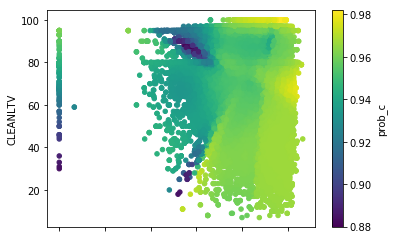

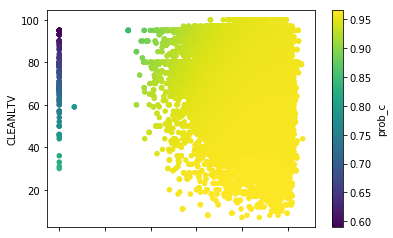

In [34]:
def extract(row):
    return (row.FICO, row.CLEANLTV, row.label) + (tuple(row.probability.toArray().tolist()))

packed_mlp = res_mlp.rdd.map(extract).toDF(["FICO", "CLEANLTV", "label", "prob_p", "prob_c", "prob_3"])
packed_logistic = res_logistic.rdd.map(extract).toDF(["FICO", "CLEANLTV", "label", "prob_p", "prob_c", "prob_3"])

packed_mlp.show()
packed_logistic.show()

#grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))
plot_frame = pd.DataFrame(packed_mlp.limit(1000000).collect(), columns=['FICO', 'CLEANLTV', 'label', "prob_p", "prob_c", "prob_3"])
plot_frame.plot(kind='scatter', x='FICO', y='CLEANLTV', c='prob_c', cmap='viridis')


plot_frame2 = pd.DataFrame(packed_logistic.limit(1000000).collect(), columns=['FICO', 'CLEANLTV', 'label', "prob_p", "prob_c", "prob_3"])
plot_frame2.plot(kind='scatter', x='FICO', y='CLEANLTV', c='prob_c', cmap='viridis')

In [41]:
res_logistic.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|99925|
+----------+-----+

